# Лабораторная работа 6. Определение объектов на изображении исползуя метод SIFT
## Цель:
Научится определять объекты на фото исползуя метод SIFT
## Ход работы
1. Взять фото объекта на однородном фоне, снятое с немного удаленного ракурса (по аналогии с книгой с примере)
2. Автоматически определить углы границы искомого объекта и сделать его разворот (пространственное пробразование)
3. Взять этот объект за эталон
4. Взятие фотографий под разными углами с объектом и без объекта
5. С использованием метода SIFT, определив пороговое значение для факта наличия предмета на изображении, произвести поиск объекта на фотографиях
6. Повторить 4 и 5 шаг несколько раз для определение точности под разными углами
7. Вывести отчет о факте наличия объекта на фотографиях. Определить точность метода.

## Подготовка окружения и создания экземпляров

In [383]:
# 1) Импорт всех необходимых библиотек
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from rich.table import Table
from gz_utils_balcon import EntityManager
import rclpy
from rclpy.wait_for_message import wait_for_message
from cv_bridge import CvBridge
from sensor_msgs.msg import Image

# 2) Инциализация `rclpy` и создания node для наблюдения за сообщениями
if not rclpy.ok():
    rclpy.init()
    node = rclpy.create_node("simple_node")

# 3) Создания CvBridge
bridge = CvBridge()

# 4) Создания экземпляра EntityManager для мира "default"
emg = EntityManager("default")

Напишим функцию для получения изображения из ros2

In [2]:
def get_image():
    msg = wait_for_message(Image,node,"/camera/rgb/image_raw",time_to_wait=10)
    if msg[0] == False:
        raise TimeoutError
    else:
        img_rgb = bridge.imgmsg_to_cv2(msg[1])
        return img_rgb


Перед решением в терминале нужно запустить симуляцию и мост следущей командой

```ros2 launch tracking_2 bringup_launch.py```

## Решение
### 1. Взять фото

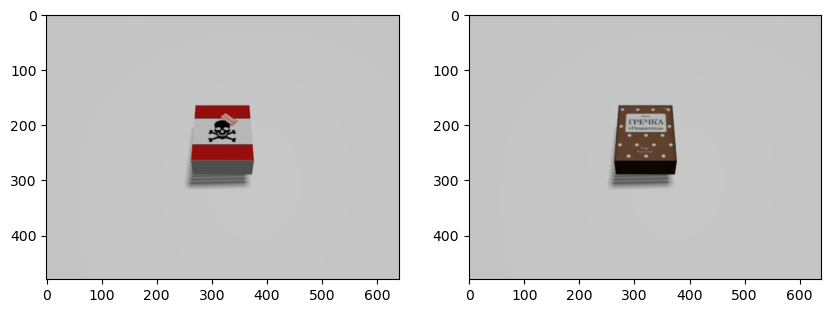

In [24]:
plt.figure(figsize = (10,10))
# Создания Яда
emg.create_entity("poison.sdf","poison")

plt.subplot(1,2,1)
poison_img = get_image()
plt.imshow(poison_img)

emg.delete_entity(["poison"])

# Создания Гречки
emg.create_entity("cereal.sdf", "cereal")

plt.subplot(1,2,2)
cereal_img = get_image()
plt.imshow(cereal_img)

emg.delete_entity(["cereal"])


### 2. Автоматически определить углы границы искомого объекта и сделать его разворот (пространственное пробразование)

In [4]:
def get_corners(img):
      """
      Returns a list of corners ((x, y) tuples) found in the input image. With proper
      pre-processing and filtering, it should output at most 10 potential corners.
      This is a utility function used by get_contours. The input image is expected
      to be rescaled and Canny filtered prior to be passed in.
      """
      rho = 1  # distance resolution in pixels of the Hough grid
      theta = np.pi / 180  # angular resolution in radians of the Hough grid
      threshold = 15  # minimum number of votes (intersections in Hough grid cell)
      min_line_length = 50  # minimum number of pixels making up a line
      max_line_gap = 20  # maximum gap in pixels between connectable line segments
      line_image = np.copy(img) * 0  # creating a blank to draw lines on

      # Run Hough on edge detected image
      # Output "lines" is an array containing endpoints of detected line segments
      lines = cv.HoughLinesP(img, rho, theta, threshold, np.array([]),
                          min_line_length, max_line_gap)

      # massages the output from LSD
      # LSD operates on edges. One "line" has 2 edges, and so we need to combine the edges back into lines
      # 1. separate out the lines into horizontal and vertical lines.
      # 2. Draw the horizontal lines back onto a canvas, but slightly thicker and longer.
      # 3. Run connected-components on the new canvas
      # 4. Get the bounding box for each component, and the bounding box is final line.
      # 5. The ends of each line is a corner
      # 6. Repeat for vertical lines
      # 7. Draw all the final lines onto another canvas. Where the lines overlap are also corners
      corners = []
      if lines is not None:
          # separate out the horizontal and vertical lines, and draw them back onto separate canvases
          lines = lines.squeeze().astype(np.int32).tolist()
          horizontal_lines_canvas = np.zeros(img.shape, dtype=np.uint8)
          vertical_lines_canvas = np.zeros(img.shape, dtype=np.uint8)
          for line in lines:
              x1, y1, x2, y2 = line
              if abs(x2 - x1) > abs(y2 - y1):
                  (x1, y1), (x2, y2) = sorted(((x1, y1), (x2, y2)), key=lambda pt: pt[0])
                  cv.line(horizontal_lines_canvas, (max(x1 - 5, 0), y1), (min(x2 + 5, img.shape[1] - 1), y2), 255, 2)
              else:
                  (x1, y1), (x2, y2) = sorted(((x1, y1), (x2, y2)), key=lambda pt: pt[1])
                  cv.line(vertical_lines_canvas, (x1, max(y1 - 5, 0)), (x2, min(y2 + 5, img.shape[0] - 1)), 255, 2)

          lines = []

          # find the horizontal lines (connected-components -> bounding boxes -> final lines)
          (contours, hierarchy) = cv.findContours(horizontal_lines_canvas, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
          contours = sorted(contours, key=lambda c: cv.arcLength(c, True), reverse=True)[:2]
          horizontal_lines_canvas = np.zeros(img.shape, dtype=np.uint8)
          for contour in contours:
              contour = contour.reshape((contour.shape[0], contour.shape[2]))
              min_x = np.amin(contour[:, 0], axis=0) + 2
              max_x = np.amax(contour[:, 0], axis=0) - 2
              left_y = int(np.average(contour[contour[:, 0] == min_x][:, 1]))
              right_y = int(np.average(contour[contour[:, 0] == max_x][:, 1]))
              lines.append((min_x, left_y, max_x, right_y))
              cv.line(horizontal_lines_canvas, (min_x, left_y), (max_x, right_y), 1, 1)
              corners.append((min_x, left_y))
              corners.append((max_x, right_y))

          # find the vertical lines (connected-components -> bounding boxes -> final lines)
          (contours, hierarchy) = cv.findContours(vertical_lines_canvas, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
          contours = sorted(contours, key=lambda c: cv.arcLength(c, True), reverse=True)[:2]
          vertical_lines_canvas = np.zeros(img.shape, dtype=np.uint8)
          for contour in contours:
              contour = contour.reshape((contour.shape[0], contour.shape[2]))
              min_y = np.amin(contour[:, 1], axis=0) + 2
              max_y = np.amax(contour[:, 1], axis=0) - 2
              top_x = int(np.average(contour[contour[:, 1] == min_y][:, 0]))
              bottom_x = int(np.average(contour[contour[:, 1] == max_y][:, 0]))
              lines.append((top_x, min_y, bottom_x, max_y))
              cv.line(vertical_lines_canvas, (top_x, min_y), (bottom_x, max_y), 1, 1)
              corners.append((top_x, min_y))
              corners.append((bottom_x, max_y))

          # find the corners
          corners_y, corners_x = np.where(horizontal_lines_canvas + vertical_lines_canvas == 2)
          corners += zip(corners_x, corners_y)

      # remove corners in close proximity
      # corners = filter_corners(corners)
      return corners

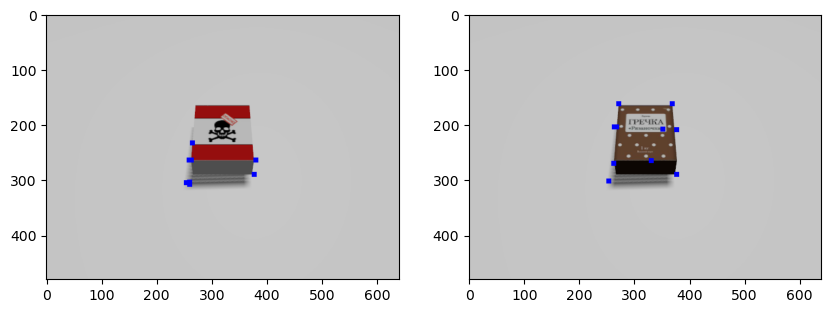

In [27]:
poison_gray = cv.cvtColor(poison_img, cv.COLOR_RGB2GRAY)
cereal_gray = cv.cvtColor(cereal_img, cv.COLOR_RGB2GRAY)
poison_edged = cv.Canny(poison_gray, 30, 150)
cereal_edged = cv.Canny(cereal_gray, 30, 150)
poison_corners = get_corners(poison_edged)
cereal_corners = get_corners(cereal_edged)

poison_img_copy = poison_img.copy()
cereal_img_copy = cereal_img.copy()

poison_img_copy = poison_img.copy()

rows, cols = zip(*poison_corners)
mask_poison = np.zeros(poison_img_copy.shape[:2])
mask_poison[cols, rows] = 1
mask_poison = cv.dilate(mask_poison, None, iterations=4)

rows, cols = zip(*cereal_corners)
mask_corners = np.zeros(cereal_img_copy.shape[:2])
mask_corners[cols, rows] = 1
mask_corners = cv.dilate(mask_corners, None, iterations=4)
poison_img_copy[mask_poison>0] = [0,0,255]
cereal_img_copy[mask_corners>0] = [0,0,255]


plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(poison_img_copy)

plt.subplot(1,2,2)
plt.imshow(cereal_img_copy)

Сделаем разворот, так как объекты расположены в одном и том же месте с одинаковыми размеры то обеденим два масива точек и определим 4 точки для двух изображений

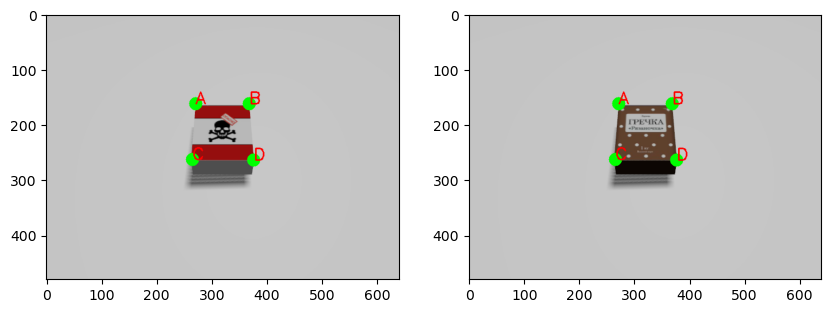

In [138]:
poison_img_copy = poison_img.copy()
cereal_img_copy = cereal_img.copy()


A = (271,162)
B = (368,162)
C = (265,259+4)
D = (380-4,264)
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
cv.circle(poison_img_copy, A, 12, (0,255,0), -1, 8)
cv.circle(poison_img_copy, B, 12, (0,255,0), -1, 8)
cv.circle(poison_img_copy, C, 12, (0,255,0), -1, 8)
cv.circle(poison_img_copy, D, 12, (0,255,0), -1, 8)
cv.putText(poison_img_copy, 'A', A, cv.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)
cv.putText(poison_img_copy, 'B', B, cv.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)
cv.putText(poison_img_copy, 'D', D, cv.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)
cv.putText(poison_img_copy, 'C', C, cv.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)
plt.imshow(poison_img_copy)

plt.subplot(1,2,2)
# cv.circle(cereal_img_copy, cliping_points["A"], 12, (0,255,0), -1, 8)
cv.circle(cereal_img_copy, A, 12, (0,255,0), -1, 8)
cv.circle(cereal_img_copy, B, 12, (0,255,0), -1, 8)
cv.circle(cereal_img_copy, C, 12, (0,255,0), -1, 8)
cv.circle(cereal_img_copy, D, 12, (0,255,0), -1, 8)
cv.putText(cereal_img_copy, 'A', A, cv.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)
cv.putText(cereal_img_copy, 'B', B, cv.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)
cv.putText(cereal_img_copy, 'D', D, cv.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)
cv.putText(cereal_img_copy, 'C', C, cv.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)
plt.imshow(cereal_img_copy)

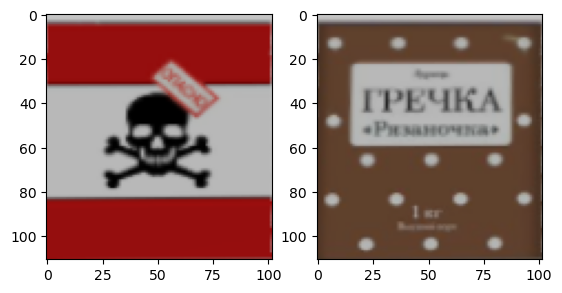

In [139]:
h_AB = np.sqrt(((A[0] - B[0])**2) + ((A[1] - B[1])**2))
h_CD = np.sqrt(((C[0] - D[0])**2) + ((C[1] - D[1])**2))
max_h = max(int(h_AB), int(h_CD))

w_AC = np.sqrt(((A[0] - C[0])**2) + ((A[1] - C[1])**2))
w_BD = np.sqrt(((B[0] - D[0])**2) + ((B[1] - D[1])**2))
max_w = max(int(w_AC), int(w_BD))

input_pts = np.float32([A, C, D, B])
output_pts = np.float32([[0,0],
                         [0, max_h - 1],
                         [max_w - 1, max_h - 1],
                         [max_w - 1, 0]])
poison_img_clip = poison_img.copy()
cereal_img_clip = cereal_img.copy()
M = cv.getPerspectiveTransform(input_pts, output_pts)
poison_img_clip = cv.warpPerspective(poison_img_clip, M, (max_w, max_h), flags=cv.INTER_LINEAR)
cereal_img_clip = cv.warpPerspective(cereal_img_clip, M, (max_w, max_h), flags=cv.INTER_LINEAR)

plt.subplot(1,2,1)
plt.imshow(poison_img_clip)

plt.subplot(1,2,2)
plt.imshow(cereal_img_clip)

## 3. Взять этот объект за эталон

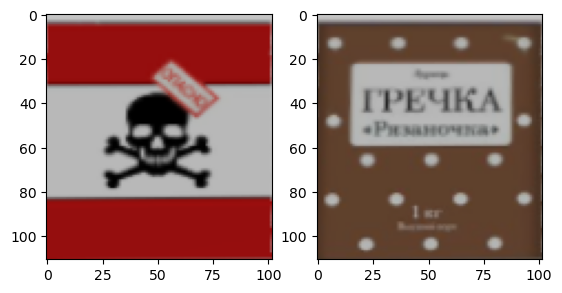

In [140]:
plt.subplot(1,2,1)
plt.imshow(poison_img_clip)

plt.subplot(1,2,2)
plt.imshow(cereal_img_clip)

### 4. Взятие фотографий под разными углами с объектом и без объекта

In [186]:
def get_10_photo(sdf_name):
    return_ls = []
    for i in range(1,11):
        y = ((3.14*2)/10)*i
        emg.create_entity(sdf_name,yaw=y)
        img = get_image()
        return_ls.append(img)
        emg.delete_entity(["unknow"])
        time.sleep(0.1) #Время на обработку запроса
        
    return return_ls        

poison_imgs = get_10_photo("poison.sdf")
cereal_imgs = get_10_photo("cereal.sdf")
    

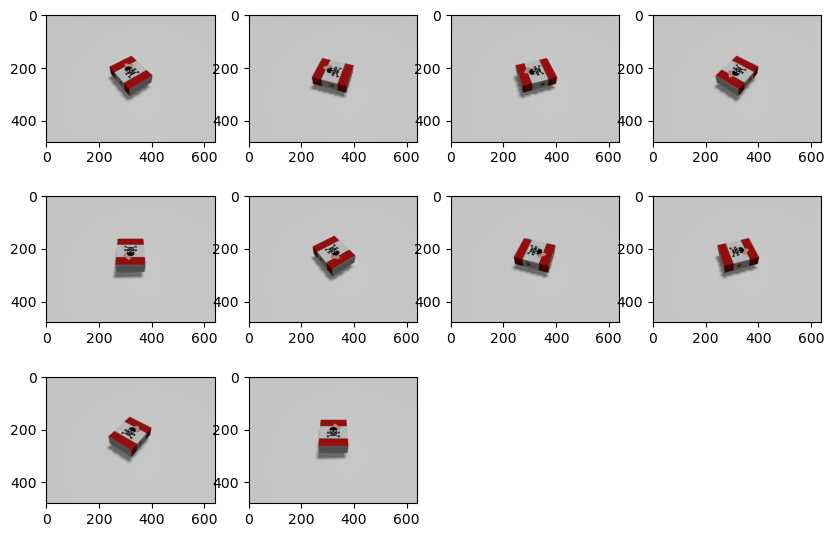

In [194]:
plt.figure(figsize=(10,9))
for i in range(10):
    plt.subplot(4,4,i+1)
    plt.imshow(poison_imgs[i])

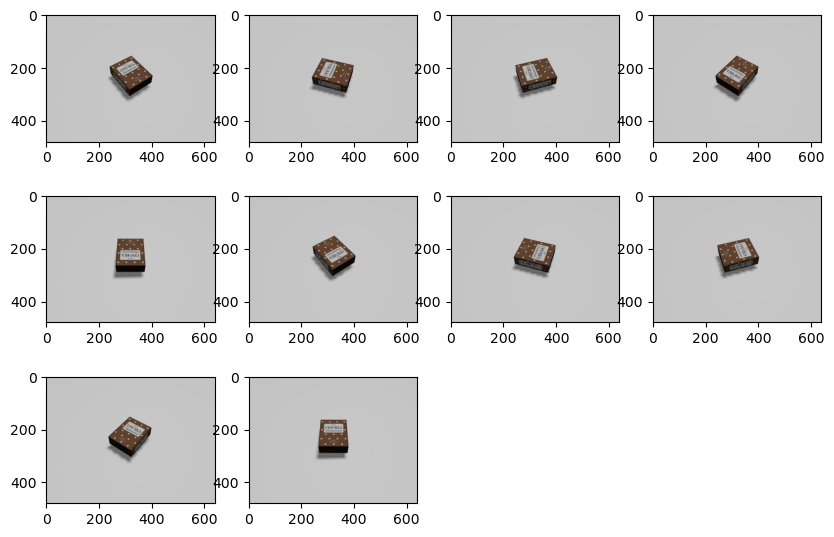

In [195]:
plt.figure(figsize=(10,9))

for i in range(10):
    plt.subplot(4,4,i+1)
    plt.imshow(cereal_imgs[i])

### 5. С использованием метода SIFT, определив пороговое значение для факта наличия предмета на изображении, произвести поиск объекта на фотографиях

In [312]:
def get_points(img1,img2):
    sift = cv.SIFT_create()
    bf = cv.BFMatcher()
    img1_gray = cv.cvtColor(img1,cv.COLOR_RGB2GRAY)
    img2_gray = cv.cvtColor(img2,cv.COLOR_RGB2GRAY)
    kp_1, des_1 = sift.detectAndCompute(img1_gray, None)
    kp_2, des_2 = sift.detectAndCompute(img2_gray, None)

    matches = bf.knnMatch(des_1, des_2, k=2)

    good = []
    for n,m in matches:
      if (n.distance < 0.6* m.distance):
        good.append([m])
    
    img3 = cv.drawMatchesKnn(img1, kp_1, img2, kp_2,
                              good, None, flags = cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    
    return (len(good), img3)
        

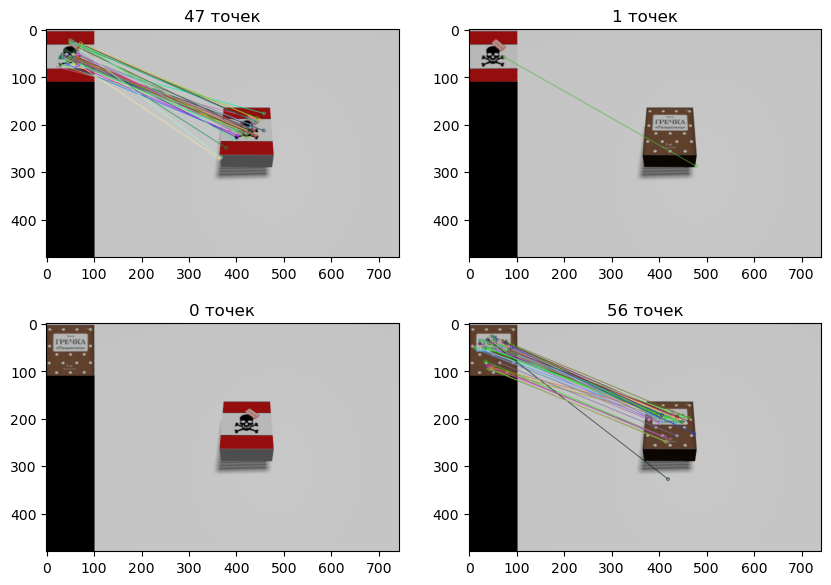

In [320]:
plt.figure(figsize=(10,7))
plt.subplot(2,2,1)
count_points, img = get_points(poison_img_clip,poison_imgs[i])
plt.title(f"{count_points} точек")
plt.imshow(img)

plt.subplot(2,2,2)
count_points, img = get_points(poison_img_clip,cereal_imgs[i])
plt.title(f"{count_points} точек")
plt.imshow(img)

plt.subplot(2,2,3)
count_points, img = get_points(cereal_img_clip,poison_imgs[i])
plt.title(f"{count_points} точек")
plt.imshow(img)

plt.subplot(2,2,4)
count_points, img = get_points(cereal_img_clip,cereal_imgs[i])
plt.title(f"{count_points} точек")
plt.imshow(img)
plt.show()

При идиальных условиях количество точек может быть явно больше 50 и при этом если фото не совпадают то количество точек близко к 0. Поэтому если точек больше 20 то условия выполняется

### 6. Повторить 4 и 5 шаг несколько раз для определение точности под разными углами

In [436]:
def test(bound):
    def what_is(poison_count_points):
        if (poison_count_points>bound):
            return "poison"
        else:
            return "none"
        
    true_positive = 0  # Ответ правда и это правильный ответ
    true_negative = 0  # Ответ не правда и это правильный ответ
    false_positive = 0 # Ответ правда и это не правильный ответ
    false_negative = 0 # Ответ не правда и это не правильный ответ
    for img in poison_imgs:
        poison_count_points, img = get_points(poison_img_clip,img)
        match what_is(poison_count_points):
            case "poison":
                true_positive += 1
            case _:
                false_negative +=1
                
    
    for img in cereal_imgs:
        poison_count_points, img = get_points(poison_img_clip,img)
        match what_is(poison_count_points):
            case "poison":
                false_positive +=1
            case _:
                true_negative +=1
            
    return true_positive, true_negative, false_positive, false_negative

true_positive, true_negative, false_positive, false_negative = test(20)

### 7. Вывести отчет о факте наличия объекта на фотографиях. Определить точность метода.

In [442]:
from rich.table import Column, Table

table = Table(
    "Характеристика",
    "Значения",
)

table.add_row("True positive", f"{true_positive}")
table.add_row("True_negative", f"{true_negative}")
table.add_row("False positive", f"{false_positive}")
table.add_row("False negative", f"{false_negative}")
print(table)

table = Table(
    "Характеристика",
    "Значения",
)

acc = (true_positive + true_negative)/(true_positive + false_positive+ false_negative + true_negative)
pres = true_positive/(true_positive+false_positive)
recall = true_positive/(true_positive+false_negative) 
spec = true_negative/(true_negative+false_positive) 
f1score = (pres * recall)/(pres + recall)


table.add_row("Точность", f"{acc:.2f}")
table.add_row("pres", f"{pres:.2f}")
table.add_row("recall", f"{recall:.2f}")
table.add_row("spec", f"{spec:.2f}")
table.add_row("f1 score", f"{f1score:.2f}")
print(table)

┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Характеристика ┃ Значения ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ True positive  │ 7        │
│ True_negative  │ 10       │
│ False positive │ 0        │
│ False negative │ 3        │
└────────────────┴──────────┘

┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Характеристика ┃ Значения ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ Точность       │ 0.85     │
│ pres           │ 1.00     │
│ recall         │ 0.70     │
│ spec           │ 1.00     │
│ f1 score       │ 0.41     │
└────────────────┴──────────┘